In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Note

It seems like there might be an issue with the derivation below. A simpler answer is found here:

https://www.mathworks.com/matlabcentral/answers/658673-create-random-points-in-elliptical-belt#answer_553348



We want to generate uniformly distributed random points located between two ellipses. The outer ellipse will have a semi-major axis $a$ and semi-minor axis $b$. The inner ellipse will have a semi-major axis $ka$ and a semi-minor axis $kb$, with $0 \le k \lt 1$.

In [2]:
ell_a = 6   # Outer ellipse semi-major axis
ell_b = 2   # Outer ellipse semi-minor axis
ell_k = 0.5 # Ratio of inner ellipse to outer ellipse

The polar form of the an ellipse with semi-major axis $a$ and semi-minor axis $b$ is given by:

$$r(\theta) = \frac{a b}{\sqrt{b^2 \cos^2 \theta + a^2 \sin^2 \theta}}$$

In [3]:
def EllipseRadius(a, b, angle):
    return a * b / np.sqrt((b * np.cos(angle)) ** 2 + (a * np.sin(angle)) ** 2)

Let's use this to draw the two ellipses.

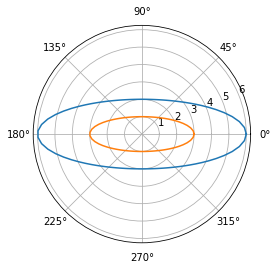

In [4]:
fig = plt.figure()
ax = fig.add_subplot(projection='polar')

angles = np.linspace(0, 2 * np.pi, 100)

rs = EllipseRadius(ell_a, ell_b, angles)
ax.plot(angles, rs)

rs = EllipseRadius(ell_k * ell_a, ell_k * ell_b, angles)
ax.plot(angles, rs);

Our strategy will be to find the total area of the annulus, $A_{total}$, then choose a random number $A_{sample}$ with $0 \le A_{sample} \lt A_{total}$. Then we will determine $x$ so that:

$$
A_{sample} = \int_{0}^{x} A(\theta) \,d\theta
$$

To do this, we will need to solve the following integral[<sup>1</sup>](#fn1):

$$
A_{partial} = \int_{0}^{x} \int_{0}^{r(\theta)} r \,dr \,d\theta = \int_{0}^{x} \frac{r(\theta)^2}{2} \,d\theta = \frac{a^2 b^2}{2} \int_{0}^{x} \frac{\,d\theta}{b^2 \cos^2 \theta + a^2 \sin^2 \theta}
$$

We rewrite this integral as:

$$
A_{partial} = \frac{a^2 b^2}{2} \int_{0}^{x} \frac{\sec^2 \theta \,d\theta}{b^2 + a^2 \tan^2 \theta}
$$

Then we make the following change of variables:

$$
a \tan \theta = b \tan \phi \implies a \sec^2 \theta \,d\theta = b \sec^2 \phi \,d\phi
$$

This gives:

$$
A_{partial} = \frac{a^2 b^2}{2} \int_{0}^{y} \frac{(b/a) \sec^2 \phi \,d\phi}{b^2 (1 + \tan^2 \phi)}
$$

with:

$$
y = \tan^{-1} \left( {\frac{a}{b} \tan x} \right)
$$

Using the Pythagorean identity, $1 + tan^2 \phi = \sec^2 \phi$, we get:

$$
A_{partial} = \frac{a^2 b^2}{2} \int_{0}^{y} \frac{(b/a) \sec^2 \phi \,d\phi}{b^2 \sec^2 \phi} = \frac{a^2 b^2}{2} \int_{0}^{y} \frac{(b/a) \,d\phi}{b^2} = \frac{a b}{2} \int_{0}^{y} \,d\phi
$$

Substituting the expression for $y$, we get:

$$
A_{partial} = \frac{a b}{2} \tan^{-1} \left( {\frac{a}{b} \tan x} \right)
$$

This gives us the partial area for an ellipse. To get the partial area of the annulus, we take:

$$
A_{sample} = A_{outer} - A_{inner} = \frac{a b}{2} \tan^{-1} \left( {\frac{a}{b} \tan x} \right) - \frac{k^2 a b}{2} \tan^{-1} \left( {\frac{a}{b} \tan x} \right) = \frac{a b (1 - k^2)}{2} \tan^{-1} \left( {\frac{a}{b} \tan x} \right)
$$

Finally, we solve for x:

$$
x = \tan^{-1} \left( \frac{b}{a} \tan \left( 2 \frac{A_{sample}}{a b (1 - k^2)} \right) \right)
$$

Let's try this out:

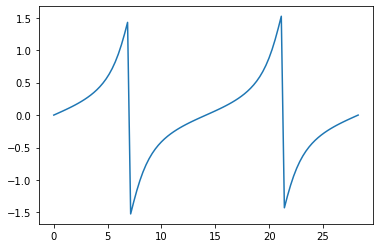

In [5]:
def AnnulusAngle(a, b, k, area):
    return np.arctan(b / a * np.tan(2 * area / (a * b * (1 - k**2))))

area_annulus = np.pi * ell_a * ell_b * (1 - ell_k**2)
xs = np.linspace(0, area_annulus, 100)
ys = AnnulusAngle(ell_a, ell_b, ell_k, xs)

plt.plot(xs, ys);

This is really close, but we're running into an issue because if the ambiguity of $\tan^{-1}(u)$.

The area of an ellipse with semi-major axis $a$ and semi-minor axis $b$ is given by $A = \pi ab$. So the area inside the annulus is:

$$
A_{total} = \pi ab (1-k^2)
$$

Then we can rewrite the expression for $x$ as:

$$
x = \tan^{-1} \left( \frac{b}{a} \tan \left( 2 \pi \frac{A_{sample}}{A_{total}} \right) \right)
$$

This suggests that we can reorganize the expression to retain information about what quadrant the angle represents:

$$
x = \tan^{-1} \left( \frac{b}{a} \frac{ \sin \alpha}{ \cos \alpha} \right)
$$

with:

$$
\alpha = 2 \pi \frac{A_{sample}}{A_{total}}
$$

Going back to the code:

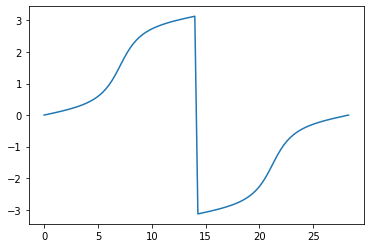

In [6]:
def AnnulusAngle(a, b, k, area):
    area_total = np.pi * a * b * (1 - k**2)
    alpha = 2 * np.pi * area / area_total
    return np.arctan2(b / a * np.sin(alpha), np.cos(alpha))

area_annulus = np.pi * ell_a * ell_b * (1 - ell_k**2)
xs = np.linspace(0, area_annulus, 100)
ys = AnnulusAngle(ell_a, ell_b, ell_k, xs)

plt.plot(xs, ys);

That's it!

At this point, we've taken a random portion of the total area of the annulus, and determined what angle divides the annulus with that area on one side. Next, we need to determine the radius of the random point. Our strategy will be similar to the one we've just used. First we will determine the total size of the area element at our chosen angle, then we will find the radius which divides the area element with that area on one side.

The area of an angular element with radius $x$ is given by:

$$
A = \int_{0}^{x} r dr = \frac{x^2}{2}
$$

We can also solve this for $x$ to get the inverse relation:

$$
x = \sqrt{2 A}
$$

Finally, we can put all this together to get a random point within the annulus:

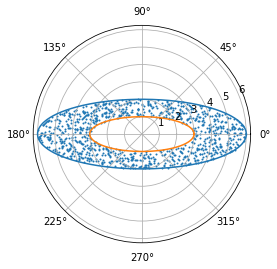

In [7]:
def RandomPoint(a, b, k):
    # Total area of the annulus
    area_total = np.pi * a * b * (1 - k**2)
    
    # Random sample from within that area
    area_sample = np.random.rand() * area_total
    
    # Figure out what angle that corresponds with
    theta = AnnulusAngle(a, b, k, area_sample)
    
    # Get the inner and outer radius of the annulus at that angle
    r_outer = EllipseRadius(a, b, theta)
    r_inner = EllipseRadius(k*a, k*b, theta)

    # Get area element corresponding to these two
    a_outer = r_outer**2 / 2
    a_inner = r_inner**2 / 2
    
    # Get a random area in that range
    a_random = a_inner + np.random.rand() * (a_outer - a_inner)
    
    # Finally, get the radius corresponding with that area
    radius = np.sqrt(2 * a_random)
    
    return (theta, radius)

rs = []
angles = []

for _ in range(1000):
    theta, radius = RandomPoint(ell_a, ell_b, ell_k)
    rs.append(radius)
    angles.append(theta)

fig = plt.figure()
ax = fig.add_subplot(projection='polar')
ax.scatter(angles, rs, 1)

angles = np.linspace(0, 2 * np.pi, 1000)

rs = EllipseRadius(ell_a, ell_b, angles)
ax.plot(angles, rs)

rs = EllipseRadius(ell_k*ell_a, ell_k*ell_b, angles)
ax.plot(angles, rs);

# References

1. <span id="fn1">https://www.usna.edu/Users/physics/mungan/_files/documents/Scholarship/EllipsePolarCoors.pdf</span>